In [3]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import imageio  
%matplotlib inline

## Overview
Our goal is create a parametrized linear regression model under additive Gaussian noise:

$$f(x)=\theta_0 + \theta_1x$$ so that $y=f(x) + \epsilon$. The parameters $\mathbf{\theta}$ can be found by sequentially collecting samples $\mathcal{D}:=(X,\mathbf{y})=\{(x_n,y_n)\}_{n=1}^N$ from the target function and using this data in the Bayesian framework to approach the true value of parameters. However, finding the parameter distribution is merely an intermediate goal. Once we have established the distribution of coefficients through Bayesian treatment, we are able to predict y for every new input $\mathbf{x}$:

$$p(y|X, \mathcal{D}) = \int p(y|X,\mathbf{\theta})p(\mathbf{\theta}|\mathcal{D})d\mathbf{\theta}$$


The Bayesian model assigns this probability to each value of y for a given x to arrive at a probability distribution over parameters and not only point estimates. Additionally, the Bayesian approach does not suffer from over-fitting.
The prior is chosen to be a Gaussian distribution, 

$$p(\mathbf{\theta})=\mathcal{N}(\mathbf{\theta}|\mu, \Sigma)$$

with mean $\mu=\mathbf{0}$ and the variance $\Sigma=\alpha^{-1}\mathbf{I}$ is governed by a precision parameter $\alpha$ so that the prior is isotrophic. $\beta$ is the precision of the Gaussian additive noise $\epsilon$:

$$p(y|X, \mathbf{\theta}) = \mathcal{N}(y| f(X), \beta^{-1}).$$


The constructor shows the experimental setup. We define precision parameters $\alpha=2$ and $\beta=25$, as well as the coefficients $\mathbf{\theta}$ of the “unknown” linear function:

$$f(\mathbf{x}) = \theta_0+\theta_1x = -0.3 + 0.5x$$

We visualize the likelihood distribution which identifies which parameters are likely generated by the given batch of data. The log likelihood function:

$$\ln p(\mathcal{D}|\mathbf{\theta})= \frac{N}{2}\ln\beta - \frac{N}{2}\ln(2\pi) - \frac{\beta}{2}\sum^N_{n=1}\{y_n-\mathbf{\theta}^T\mathbf{x}_n\}^2$$
viewed as a function of $\mathbf{\theta}$ is
$$p(\mathcal{D}|\mathbf{\theta})\propto \exp(-\sum^N_{n=1}\{y_n-\mathbf{\theta}^T\mathbf{x}_n\}^2)$$.


## Posterior

The posterior is proportional to the product of the likelihood function and the prior:

$$p(\mathbf{\theta}|\mathcal{D})=\mathcal{N}(\mathbf{\theta}| \mu',\Sigma') \propto p(\mathcal{D}|\mathbf{\theta}) p(\mathbf{\theta})$$
and the moments are:
$$\mu' = \Sigma'(\Sigma^{-1}\mu + \beta X^T\mathbf{y})$$
$$\Sigma' = (\Sigma^{-1} + \beta XX^T)^{-1}$$

which are used in the function $\verb|update_prior|$.


## Predictive Distribution

Finally, the predictive distribution is estimated from the formula:
$$p(y|X, \mathcal{D}) = \int p(y|X,\mathbf{\theta})p(\mathbf{\theta}|\mathcal{D})d\mathbf{\theta}$$
which is obtained by convolving two Gaussians:

$$p(y|X, \mathcal{D})=\mathcal{N}(y|\mu_*,\Sigma_*)$$
with
$$\mu_* = X^T\mu'$$
$$\Sigma_* = \beta^{-1} + X^T\Sigma'X$$



In [4]:
class SequentialBayes:
    """
    Sequential Bayesian learning class.
    """
    def __init__(self):
        """
        In the constructor we define our prior - zero-mean isotropic Gaussian governed by single precision parameter alpha = 2;
        N(\theta|0, alpha**(-1)*I)
        """
        self.theta_0 = -0.3         # First parameter of the linear function.
        self.theta_1 = 0.5          # Second parameter of the linear function.
        self.alpha = 2          # Precision of the prior.
        self.beta = 25          # Precision of the noise.
        self.iteration = 0      # Hold information about the current iteration.

        self.prior_mean = [0, 0]
        self.prior_cov = 1/self.alpha * np.eye(2)
        self.prior_distribution = tfd.MultivariateNormalFullCovariance(loc=self.prior_mean, covariance_matrix=self.prior_cov)
    
    
    # Linear function method is used to generate synthetic data from the “unknown”, target function.
    def linear_function(self, X, noisy=True):
        """
        Target, linear function y(x,theta_0,theta_1) = theta_0 + theta_1 * x.
        By default, generated samples are also affected by Gaussian noise modeled by parameter beta.

        :param X: tf.Tensor of shape (N,), dtype=float32. Those are inputs to the linear function.
        :param noisy: boolean. Decides whether we should compute noisy or noise-free output.
        :return: tf.Tensor of shape=(N,), dtype=float32. Those are outputs from the linear function.
        """
        if noisy:
            noise_distribution = tfd.Normal(loc=0, scale=1 / np.sqrt(self.beta))
            return self.theta_0 + self.theta_1 * X + tf.cast(noise_distribution.sample(len(X)), tf.float32)
        else:
            return self.theta_0 + self.theta_1 * X

    # A design matrix is a matrix containing data about multiple characteristics of several individuals or objects. 
    # It is N×M matrix, where rows are equal to the number of samples and columns to the number of features. 
    # In our particular example, the design matrix will have two columns and a variable number of rows. 
    # The first column corresponds to the \theta_0 parameters and is a vector of ones. 
    # The second column corresponds to the \theta_1 and contains vector [x_1,x_2,...,x_N]^T.     
        
    def get_design_matrix(self, X):
        """
        Computes the design matrix of size (NxM) for feature vector X.
        Here the function simply adds the unit vector.
                
        :param X: tf.Tensor of shape (N,), dtype=float32. Those are inputs to the linear function.
        :return: NxM design matrix.
        """
        N = len(X)
        M = len(self.prior_mean)
        design_mtx = np.ones((N, M))
        design_mtx[:, 1] = X
        return design_mtx
    # This method performs the update step for the sequential learning. 
    # Once the posterior is computed, it becomes the prior for the next iteration
    def update_prior(self, X, T):
        """
        Single learning iteration, where we use Bayes' Theorem to calculate the new posterior over model's parameters.
        Finally, the computed posterior becomes the new prior.
        :param X: tf.Tensor of shape (N,), dtype=float32. Feature vector.
        :param T: tf.Tensor of shape=(N,), dtype=float32. Regression target.
        """
        design_mtx = self.get_design_matrix(X)

        self.posterior_cov = np.linalg.inv(np.linalg.inv(self.prior_cov) + self.beta * design_mtx.T.dot(design_mtx))
        self.posterior_mean = self.posterior_cov.dot(np.linalg.inv(self.prior_cov).dot(self.prior_mean)
                                                     + self.beta * design_mtx.T.dot(T))
        self.posterior_distribution = tfd.MultivariateNormalFullCovariance(loc=self.posterior_mean,
                                                                 covariance_matrix=self.prior_cov)
        self.prior_mean = self.posterior_mean
        self.prior_cov = self.posterior_cov
        self.prior_distribution = self.posterior_distribution

        self.iteration += 1
        
    # This method plots a prior/posterior distribution in every iteration. Additionally, 
    # we mark the point (\theta_0,\theta_1) to see how quickly the posterior converges to our solution.
    def plot_prior(self):
        """
        Plot prior (posterior) distribution in parameter space. Also include the point, which indicates target parameters.
        """
        x = np.linspace(-1, 1, 100)
        y = np.linspace(-1, 1, 100)
        theta_0, theta_1 = np.meshgrid(x, y)

        z = self.prior_distribution.prob(np.dstack((theta_0, theta_1)))

        plt.contourf(x, y, z, cmap='plasma')
        plt.plot(self.theta_0, self.theta_1, marker = 'x', c = 'orange')    # indicate target parameters in the plot
        plt.title("Prior/Posterior Plot (iteration {})".format(self.iteration))
        plt.xlabel("$\\theta_0$")
        plt.ylabel("$\\theta_1$")
        ax = plt.axes()
        ax.set_xlim(-1, 1)
        ax.set_ylim(-1, 1)
        plt.savefig('Prior_Posterior-{}.png'.format(self.iteration))
        #plt.clf()
        plt.show()

    def plot_likelihood(self, X, T):
        """
        Plot likelihood distribution in parameter space. Also include the point, which indicates target parameters.
        :param X: tf.Tensor of shape (N,), dtype=float32. Feature vector.
        :param T: tf.Tensor of shape=(N,), dtype=float32. Regression target.
        """

        x = np.linspace(-1, 1, 100)
        y = np.linspace(-1, 1, 100)
        theta_0, theta_1 = np.meshgrid(x, y)

        least_squares_sum = 0
        for point, target in zip(X, T):
            least_squares_sum += (target - (theta_0 + theta_1 * point))**2
        z = np.exp(-self.beta*least_squares_sum)

        plt.contourf(x, y, z, cmap='plasma')
        plt.plot(self.theta_0, self.theta_1, marker='x', c='orange')  # indicate target parameters in the plot
        plt.title("Likelihood Plot (iteration {})".format(self.iteration))
        plt.xlabel("$\\theta_0$")
        plt.ylabel("$\\theta_1$")
        ax = plt.axes()
        ax.set_xlim(-1, 1)
        ax.set_ylim(-1, 1)
        plt.show()
        plt.savefig('Likelihood-{}.png'.format(self.iteration))
        #plt.clf()

    def plot_data_space(self, X, T, stdevs = 1):
        """
        Plot sampled datapoints, confidence bounds, mean prediction and target function on one graph.
        :param X: tf.Tensor of shape (N,), dtype=float32. Feature vector.
        :param T: tf.Tensor of shape=(N,), dtype=float32. Regression target.
        :param stdevs: int, how large should our confidence bound be in terms of standard deviation
        """

        x = np.linspace(-1, 1, 100)
        predictions = self.prediction_mean_std(x)
        prediction_means = [x[0] for x in predictions]
        y_upper = [x[0] + stdevs * x[1] for x in predictions]
        y_lower = [x[0] - stdevs * x[1] for x in predictions]

        plt.title('Data Space (iteration {})'.format(self.iteration))
        plt.xlabel('$x$')
        plt.ylabel('$y$')
        ax = plt.axes()
        ax.set_xlim(-1, 1)
        ax.set_ylim(-1, 1)
        # plot generated data points
        for point, target in zip(X, T):
            plt.scatter(x=point.numpy(), y=target.numpy(), marker ='o', c='blue', alpha=0.7)
        # plot confidence bounds
        plt.fill_between(x, y_upper, y_lower, where=y_upper >= y_lower, facecolor='orange', alpha=0.3)
        # plot prediction mean
        plt.plot(x, prediction_means, '-r', label='Prediction mean', c='orange', linewidth=2.0, alpha=0.8)
        # plot real function
        plt.plot(x, self.linear_function(x, noisy = False), '-r', label='Target function', c='red', linewidth=2.0, alpha=0.8)
        plt.legend(loc='upper left')
        plt.savefig('Data_Space-{}.png'.format(self.iteration))
        #plt.clf()
        plt.show()

    def prediction_mean_std(self, X):
        """
        For every sample compute mean of the corresponding Gaussian predictive distribution,
        as well as the standard deviation.
        :param X: tf.Tensor of shape (N,), dtype=float32. Feature vector.
        :return: list of tuples, where every tuple contains floats (mean, std)
        """
        no_samples = len(X)
        design_mtx = self.get_design_matrix(X)
        prediction = []
        for index in range(no_samples):
            x = design_mtx[index, :]
            predictive_std = np.sqrt(1/self.beta + x.T.dot(self.prior_cov.dot(x)))
            predictive_mean = np.array(self.prior_mean).dot(x)
            prediction.append((predictive_mean, predictive_std))
        return prediction


def run_sequential_bayes(create_gif=True):
    samples_in_batch = 50        # batch size
    no_iterations = 20          # no of learning sequences
    samples_precision = 1000    # decimal precision of a sample

    sequential_bayes = SequentialBayes()
    samples_generator = tfd.Uniform(low=-samples_precision, high=samples_precision)

    for i in range(no_iterations):
        X = samples_generator.sample(samples_in_batch) / samples_precision
        T = sequential_bayes.linear_function(X)

        sequential_bayes.plot_likelihood(X, T)
        sequential_bayes.plot_prior()
        sequential_bayes.plot_data_space(X, T)
        sequential_bayes.update_prior(X, T)

    if create_gif:
        gif_types = ['Data_Space', 'Likelihood', 'Prior_Posterior']
        for gif_type in gif_types:
            with imageio.get_writer('{}.gif'.format(gif_type), mode='I') as writer:
                image_names = [gif_type + '-{}.png'.format(i) for i in range(no_iterations)]
                for i in image_names:
                    image = imageio.imread(i)
                    writer.append_data(image)


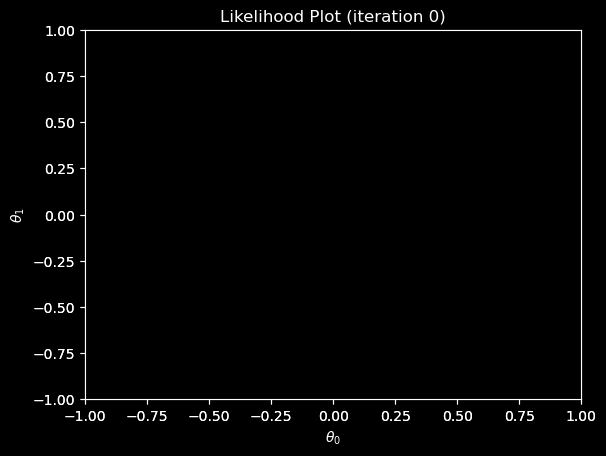

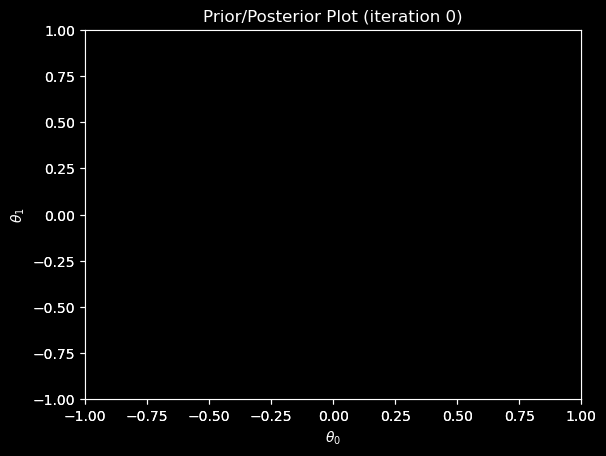

ValueError: where size (1) does not match x size (100)

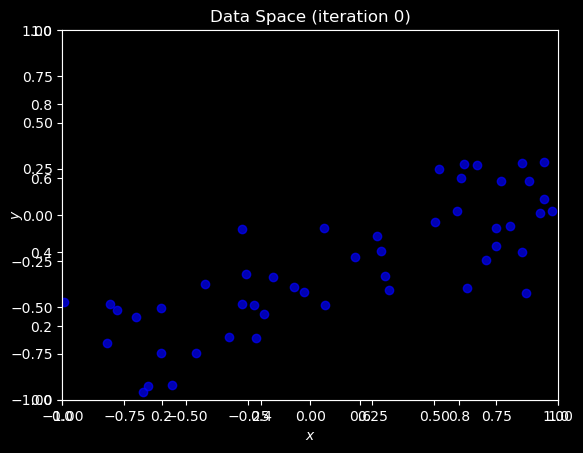

In [6]:
tfd = tfp.distributions
run_sequential_bayes(True) # set argument to true to enable writing of GIFs

The likelihood plot shows the distribution of the likelihood function over the parameter space. The true parameter values are marked with a cross. In the next plot, the prior over the parameter space is shown. In the third plot, the mean of the predictive function is initially observed to not coincide with the target function. The observations are shown as blue points. In the next iteration, the likelihood function is updated based on the new data and the posterior is shown together with the new mean of the predictive function. The prediction mean function value is now starting to coincide with the target function and the confidence bands have narrowed. After the second iteration, the likelihood function is starting to coincide with the true parameter value, the posterior is contracting to a point and the difference between the target function and the mean predictive function is converging.